In [1]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from lib.utils_simple import evaluate, compute_loss_and_f1
from lib.models import ConvLayerNorm, Block
import matplotlib.pyplot as plt

data = []
from tqdm import tqdm

experiments_dir = f'./experiments'

for experiment in tqdm(os.listdir(experiments_dir)):
    base_f1s = []
    target_f1s = []
    folds = []

    for run in os.listdir(f'{experiments_dir}/{experiment}'):
        print(f'Experiment: {experiment}, Run: {run}')
        if not os.path.exists(f'{experiments_dir}/{experiment}/{run}/metrics.json'):
            continue
        metrics = json.load(open(f'{experiments_dir}/{experiment}/{run}/metrics.json'))
        losses = json.load(open(f'{experiments_dir}/{experiment}/{run}/losses.json'))
        hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

        if 'n_base_participants' not in hyperparameters: # before I added this to hyperparameters
            hyperparameters['n_base_participants'] = len(hyperparameters['participants']) - 1

        if 'best_target_model_target_test_f1' not in metrics:
            print(f'Skipping {experiment}/{run} because no best_target_model_target_test_f1 in metrics.json')
            continue
        best_target_model_target_test_f1 = metrics['best_target_model_target_test_f1'] # temporary naming artifact

        data.append({
            'batch_size': hyperparameters['batch_size'], 
            'fold': run, 
            'best_target_model_target_test_f1': best_target_model_target_test_f1, 
            'mode': hyperparameters['mode'], 
            'target_data_pct': hyperparameters['target_data_pct'], 
            'best_custom_model_on_target_val_loss': metrics['best_base_val_loss'],
            'n_base_participants': hyperparameters['n_base_participants'],
        })
        
df = pd.DataFrame(data)
df = df[df['mode'] == 'full_fine_tuning']
df

100%|██████████| 2/2 [00:00<00:00, 582.95it/s]

Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_201205, Run: fold2_ejaz
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_201205, Run: fold1_asfik
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_201205, Run: fold0_tonmoy
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_183003, Run: fold2_ejaz
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_183003, Run: fold1_asfik
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_183003, Run: fold4_unk1
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_183003, Run: fold6_iftakhar
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_183003, Run: fold0_tonmoy
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_183003, Run: fold5_anam
Experiment: b32_aug_patience40_full_fine_tuning_pct0.05_20250930_183003, Run: fold3_alsaad


,batch_size,fold,best_target_model_target_test_f1,mode,target_data_pct,best_custom_model_on_target_val_loss,n_base_participants
0,32,fold1_asfik,0.917021,full_fine_tuning,0.05,0.028614,2
1,32,fold0_tonmoy,0.912447,full_fine_tuning,0.05,0.022881,2
2,32,fold2_ejaz,0.942262,full_fine_tuning,0.05,0.046196,1
3,32,fold1_asfik,0.917203,full_fine_tuning,0.05,0.046827,1
4,32,fold4_unk1,0.949946,full_fine_tuning,0.05,0.044630,1
5,32,fold6_iftakhar,0.928778,full_fine_tuning,0.05,0.046202,1
6,32,fold0_tonmoy,0.903051,full_fine_tuning,0.05,0.044460,1
7,32,fold5_anam,0.768038,full_fine_tuning,0.05,0.045445,1
8,32,fold3_alsaad,0.862177,full_fine_tuning,0.05,0.042978,1


<Axes: xlabel='n_base_participants', ylabel='best_target_model_target_test_f1'>

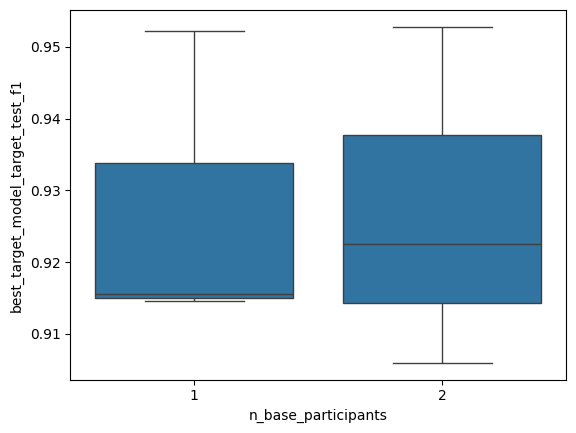

In [64]:
sns.boxplot(data=df, x='n_base_participants', y='best_target_model_target_test_f1')

<Axes: xlabel='n_base_participants', ylabel='best_target_model_target_test_f1'>

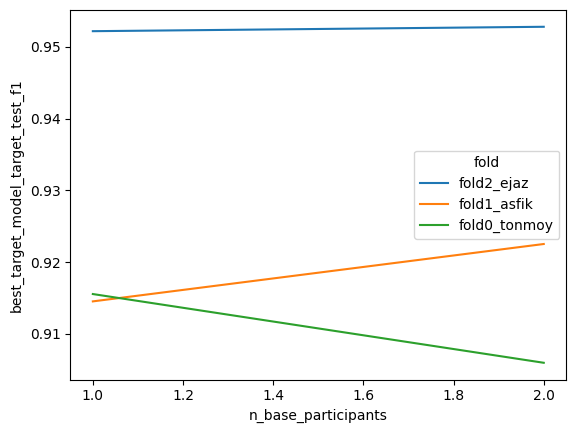

In [66]:
sns.lineplot(data=df, x='n_base_participants', y='best_target_model_target_test_f1',hue='fold')


In [ ]:

display(df)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Model Performance Analysis', fontsize=16)

# Loss plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', 
             hue='fold', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Validation Loss by Batch Size (Line Plot)')
axes[0, 0].set_ylabel('Validation Loss')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_loss', ax=axes[0, 1])
axes[0, 1].set_title('Validation Loss Distribution by Batch Size')
axes[0, 1].set_ylabel('Validation Loss')

# F1 plots
sns.lineplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', 
             hue='fold', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Validation F1 by Batch Size (Line Plot)')
axes[1, 0].set_ylabel('Validation F1')

sns.boxplot(data=df, x='batch_size', y='best_custom_model_on_target_val_f1', ax=axes[1, 1])
axes[1, 1].set_title('Validation F1 Distribution by Batch Size')
axes[1, 1].set_ylabel('Validation F1')

plt.tight_layout()
plt.show()
